In [1]:
import pandas as pd
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import h5py
import array
from collections import Counter
import daw_readout
from matplotlib.colors import LogNorm
from tqdm import trange
from tqdm import tqdm
import time  
import os 

np.set_printoptions(suppress=True) # to make tiny values appear as zero
np.set_printoptions(precision=4)   # number of digits in floats (or longfloats)
#np.set_printoptions(formatter={'float_kind':"{:.2f}"})
#np.set_printoptions()

%matplotlib inline

# Set formats
DARK=False
if(DARK==False):
    form='.k'
    plt.style.use(['default']) 
    fontcolor='k'
else:
    form='.w'
    plt.style.use(['dark_background'])
    fontcolor='w'


SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

params = {
    'font.family': 'serif',
    'font.size' : 14, 'axes.titlesize' : 14, 'axes.labelsize' : 14, 'axes.linewidth' : 1,
    # ticks
    'xtick.labelsize' : 14, 'ytick.labelsize' : 14, 'xtick.major.size' : 8, 'xtick.minor.size' : 4,
    'ytick.major.size' : 8, 'ytick.minor.size' : 4, 'xtick.major.width' : 1, 'xtick.minor.width' : 1,
    'ytick.major.width' : 1, 'ytick.minor.width' : 1, 'xtick.direction' : 'in', 'ytick.direction' : 'in',
    # markers
    'lines.markersize' : 4, 'lines.markeredgewidth' : 1, 'errorbar.capsize' : 5, 'lines.linewidth' : 1.5,
    #'lines.linestyle' : None, 'lines.marker' : None,
    'savefig.bbox' : 'tight', 'legend.fontsize' : 14,
    'axes.labelsize': 14, 'axes.titlesize':16, 'xtick.labelsize':14, 'ytick.labelsize':14,
    'backend': 'Agg', 'mathtext.fontset': 'dejavuserif',
    'figure.facecolor':'w',
    #pad
    'axes.labelpad':8,
    # ticks
    'xtick.major.pad': 7,   'xtick.minor.pad': 7,   
    'ytick.major.pad': 4, 'ytick.minor.pad': 4,
}
plt.rcParams.update(params)

In [10]:
path = "/mnt/data/PMT/R8520_406/"   ##### file path
name = "LV2415_anodereadout_LV2414_dualreadout_20240821_LED_1.7V_15ns_400_ratio_run0" 
filesnum = 1 ### number of files

hdf5_filename = path + name + ".h5"
feather_filename = path + name + ".feather"
filename = {}
filepath = {}
dataload = {}
for i in range(filesnum):
    filename[i] = name + "_raw_b0_seg" + str(i) +".bin"
    filepath[i] = path + filename[i]
    dataload[i] = daw_readout.DAWDemoWaveParser(filepath[i])




#name_3 = 'run_gamma_$(date_raw_b0_seg0.bin'

### Background data
#data0 = daw_readout.DAWDemoWaveParser([path+name[0]])#### background data


In [11]:
data = []

calbl = 10 ### Length used to calculate baseline
calstart = 95### Index started to calculate area
callen= 35  ### Length used to calculate area

for num in range(filesnum):
# Process the waveforms and store the data in lists
    i = 0
    for wave in tqdm(dataload[num]):
        baseline2 = np.sum(wave.Waveform[:calbl]) / calbl
        area = (baseline2 * callen - np.sum(wave.Waveform[calstart : calstart+callen]))
        height = (baseline2 - np.min(wave.Waveform[calstart : calstart+callen]))
        data.append({
            'Files': num,   ####file name/number
            'EventID': i,   ####index in file
            'Channel': wave.Channel, #### PMT Channel
            'Timestamp': wave.Timestamp, 
            'Baseline': wave.Baseline,
            'Baseline2': baseline2,
            'Height': height,
            'Area': area,
            'AtH':area/height,
            'Waveform':wave.Waveform
            })
        i += 1


    
# Convert lists to pandas DataFrames
df = pd.DataFrame(data)




# Print the total number of events for each channel



print("CH0 Total Events:",len(df.EventID[df.Channel==0]))
print("CH1 Total Events:",len(df.EventID[df.Channel==1]))

361095it [00:03, 107445.61it/s]


CH0 Total Events: 120365
CH1 Total Events: 120365


In [4]:
df

,Files,EventID,Channel,Timestamp,Baseline,Baseline2,Height,Area,AtH,Waveform
0,0,0,0,121296,15200,15201.1,5366.1,12822.5,2.389538,"[15198, 15200, 15202, 15199, 15202, 15199, 152..."
1,0,1,1,121296,15339,15338.9,177.9,294.5,1.655424,"[15337, 15336, 15338, 15344, 15339, 15340, 153..."
2,0,2,2,121296,8116,8115.8,2.8,-31.0,-11.071429,"[8116, 8113, 8115, 8116, 8115, 8117, 8116, 811..."
3,0,3,0,371292,15201,15201.0,6768.0,13263.0,1.959663,"[15204, 15203, 15197, 15202, 15200, 15197, 152..."
4,0,4,1,371292,15338,15340.2,140.2,323.0,2.303852,"[15340, 15343, 15339, 15340, 15340, 15340, 153..."
...,...,...,...,...,...,...,...,...,...,...
359506,0,359506,1,29958726364,15338,15337.9,49.9,62.5,1.252505,"[15341, 15334, 15339, 15338, 15338, 15335, 153..."
359507,0,359507,2,29958726364,8116,8116.5,12.5,-8.5,-0.680000,"[8118, 8115, 8118, 8116, 8113, 8118, 8113, 811..."
359508,0,359508,0,29958976364,15200,15200.8,6031.8,12179.0,2.019132,"[15203, 15204, 15204, 15197, 15201, 15204, 151..."
359509,0,359509,1,29958976364,15338,15338.3,6.3,26.5,4.206349,"[15340, 15335, 15335, 15338, 15336, 15340, 153..."


In [108]:
#n = int(input())

#plt.figure(figsize=(15,4))
#plt.title('Waveforms of two channels')
#plt.xlabel('$t$')
#plt.ylabel('adc')
#plt.xlim(90,130)
#plt.plot(df.Baseline[2*n]-df.Waveform[2*n],label='CH'+str(df.Channel[2*n])+', time = '+str(df.Timestamp[2*n]))
#plt.plot((df.Baseline[2*n+1]-df.Waveform[2*n+1]),label='CH'+str(df.Channel[2*n+1])+', time = '+str(df.Timestamp[2*n+1]))
#plt.legend()
#plt.show()

In [12]:
ch1_area = []
ch0_area = []

area_ratio = []

for i in tqdm(range(0,len(df.Area))):
    if df.Channel[i] == 1:
        ch1_area.append(df.Area[i])
    elif df.Channel[i] == 0:
        ch0_area.append(df.Area[i])

for i in tqdm(range(0,len(ch0_area))):
    area_ratio.append(ch0_area[i]/ch1_area[i])

  0%|          | 0/120365 [00:00<?, ?it/s]/tmp/ipykernel_4068544/2599490812.py:13: RuntimeWarning: divide by zero encountered in scalar divide
  area_ratio.append(ch0_area[i]/ch1_area[i])
100%|██████████| 120365/120365 [00:00<00:00, 4446741.02it/s]


/tmp/ipykernel_4068544/3173579588.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


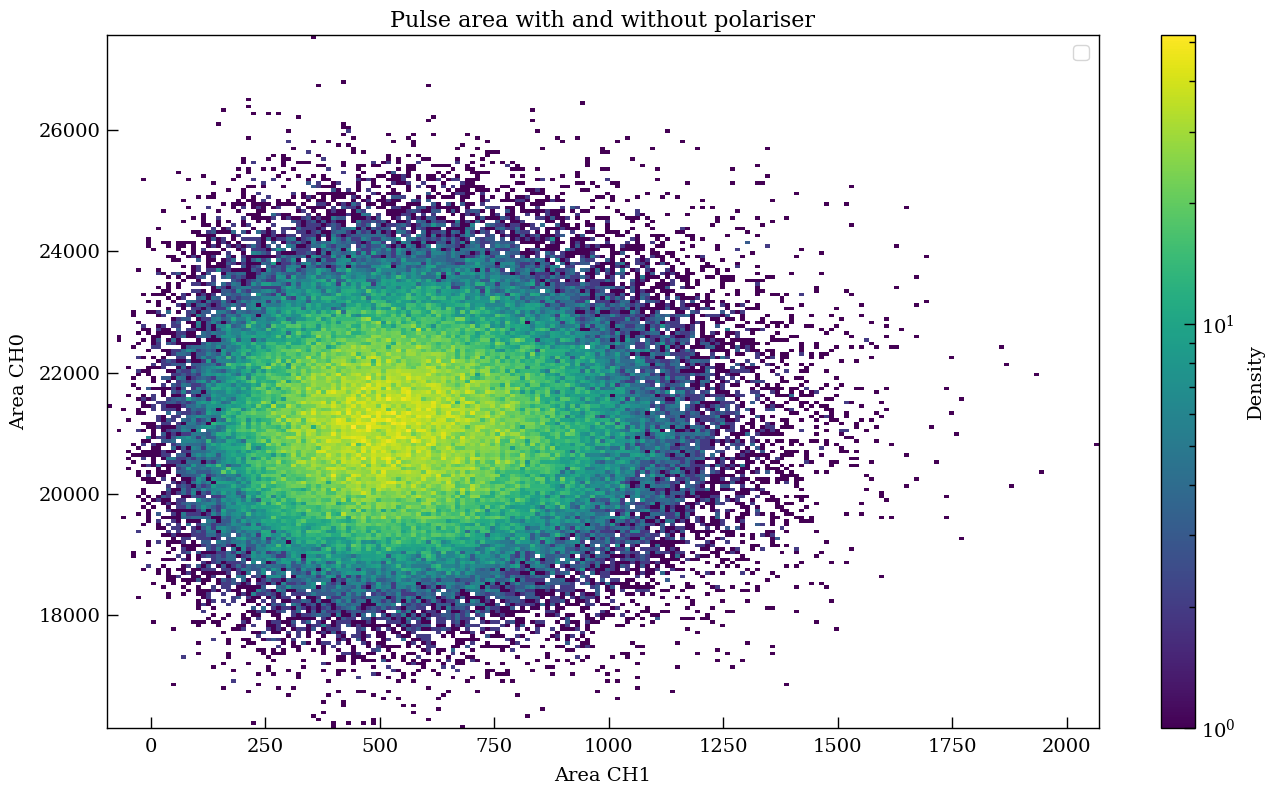

In [13]:
bin1 = np.linspace(np.min(ch1_area), np.max(ch1_area),200) ###x Height
bin2 = np.linspace(np.min(ch0_area), np.max(ch0_area), 200)###y Area
bins = [bin1,bin2]

H, xedges, yedges = np.histogram2d(ch1_area,ch0_area,bins)
H = np.rot90(H) 
H = np.flipud(H)
Hmasked = np.ma.masked_where(H==0,H)

plt.figure(figsize=(16, 9))
plt.title('Pulse area with and without polariser')
plt.xlabel('Area CH1')
plt.ylabel('Area CH0')

plt.pcolormesh(xedges,yedges,Hmasked,norm=LogNorm())
plt.colorbar(label='Density')
plt.legend()
plt.show()

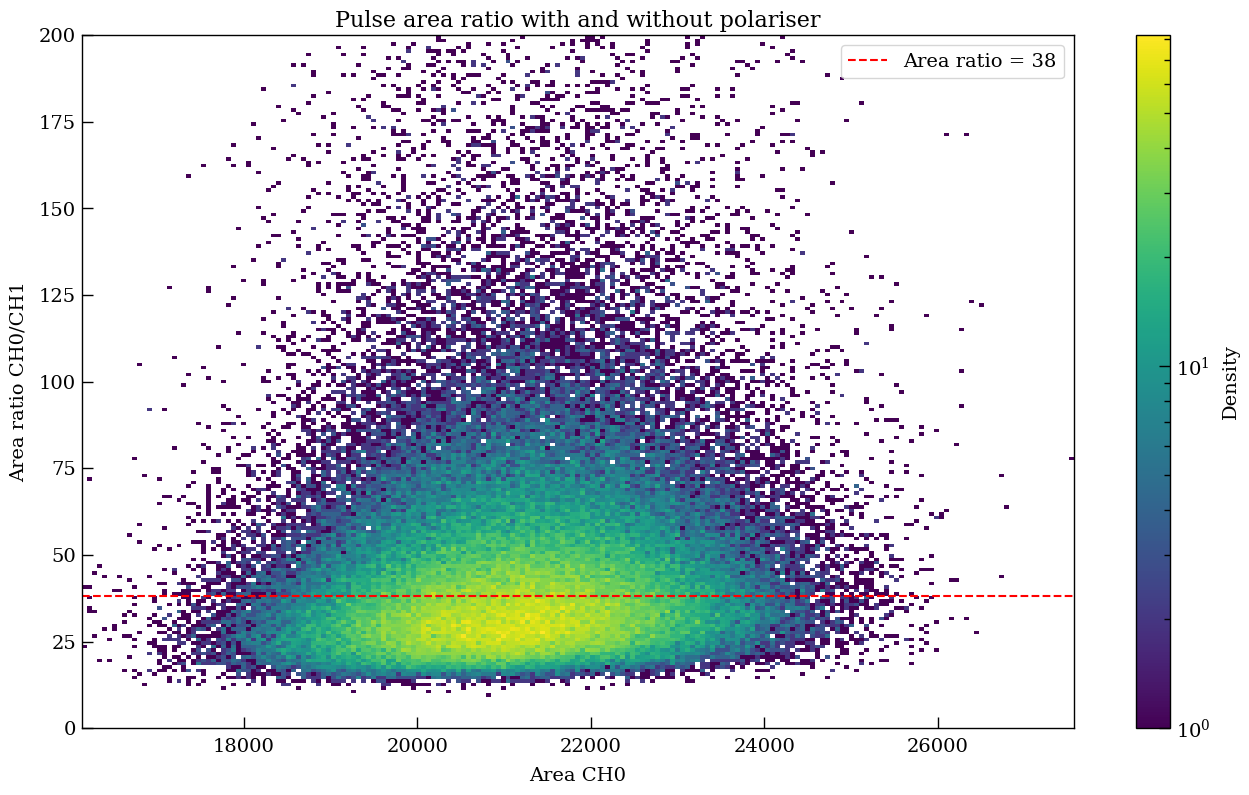

In [14]:
bin3 = np.linspace(0,200,200) ###x Height
bin4 = np.linspace(np.min(ch0_area), np.max(ch0_area), 200)###y Area
bin2s = [bin4,bin3]

H, xedges, yedges = np.histogram2d(ch0_area,area_ratio,bin2s)
H = np.rot90(H) 
H = np.flipud(H)
Hmasked = np.ma.masked_where(H==0,H)

plt.figure(figsize=(16, 9))
plt.title('Pulse area ratio with and without polariser')
plt.xlabel('Area CH0')
plt.ylabel('Area ratio CH0/CH1')

plt.pcolormesh(xedges,yedges,Hmasked,norm=LogNorm())
plt.hlines(y=38,xmin=np.min(ch0_area),xmax=np.max(ch0_area),linestyle='--',color='red',label='Area ratio = 38')
plt.colorbar(label='Density')
plt.legend()
plt.show()

In [8]:
for i in range (0,100):
    print(round(df.Area[2*i]/df.Area[2*i+1],2))

30.15
0.0
8.5
11.95
1.08
84.85
26.38
0.0
4.59
46.52
-0.04
39.21
80.41
-0.0
40.07
41.95
0.0
39.47
24.4
-0.0
-78.52
44.3
-0.01
-0.0
63.52
-0.0
-24.06
47.24
-0.0
-13.31
-0.0
0.02
-67.1
29.73
-0.0
-8.11
42.72
-0.0
-8.59
45.28
0.0
-41.11
-10.25
0.98
-39.59
58.12
-0.0
-6.21
19.98
-0.04
-0.0
53.29
-0.0
-6.25
18.3
0.0
-27.13
-0.0
0.03
17.91
39.19
0.2
-0.0
22.21
-0.0
-127.78
20.75
0.0
27.32
-18.41
0.91
-20.1
48.48
-0.0
32.23
-10.57
-2759.81
75.0
57.89
0.0
7.38
20.86
-0.0
-27.21
238.09
-0.0
-109.0
22.38
-0.0
0.0
29.73
0.0
-2.68
27.29
-0.13
0.0
130.62
1.07
-15.12
34.82


### h5 ###

In [16]:
def test_hdf5_compressed(df, filename):
    start_time = time.time()
    #df.to_hdf(filename, key='data', mode='w', complib='zlib', complevel=9)
    #充分利用多核
    df.to_hdf(filename, key='data', mode='w', complib='blosc:blosclz', complevel=9)
    
    write_time = time.time() - start_time

    file_size = os.path.getsize(filename)
    print("h5 Write Time: ", write_time)
    print("h5 File Size: ", file_size)

    return write_time,  file_size

# 添加 Feather 格式支持
def test_feather(df, filename):
    start_time = time.time()
    df.to_feather(filename)
    write_time = time.time() - start_time

    file_size = os.path.getsize(filename)
    print("feather Write Time:", write_time)
    print("feather File Size:", file_size)

    return write_time,  file_size

In [17]:
test_hdf5_compressed(df, hdf5_filename )
#test_feather(df, feather_filename)

h5 Write Time:  0.11112761497497559
h5 File Size:  8505804


(0.11112761497497559, 8505804)

In [11]:
#### Read df from .h5 and .feather
'''
start_time = time.time()
df_h5 = pd.read_hdf(hdf5_filename, key='data')
read_time = time.time() - start_time
print("h5 Read Time: ", read_time)
time0 = time
start_time = time.time()
df_feather =  pd.read_feather(feather_filename)
read_time = time.time() - start_time
print("feather Read Time: ", read_time)
'''

'\nstart_time = time.time()\ndf_h5 = pd.read_hdf(hdf5_filename, key=\'data\')\nread_time = time.time() - start_time\nprint("h5 Read Time: ", read_time)\ntime0 = time\nstart_time = time.time()\ndf_feather =  pd.read_feather(feather_filename)\nread_time = time.time() - start_time\nprint("feather Read Time: ", read_time)\n'

In [12]:
'''
for num in range(filesnum):
# Process the waveforms and store the data in lists
    i = 0
    for wave in tqdm(dataload[num]):
        baseline2 = np.sum(wave.Waveform[:calbl]) / calbl
        area = (baseline2 * callen - np.sum(wave.Waveform[calstart : calstart+callen]))
        height = baseline2 - np.min(wave.Waveform[calstart : calstart+callen])
        data.append({
            'Files': num,   ####file name/number
            'EventID': i,   ####index in file
            'Channel': wave.Channel, #### PMT Channel
            'Timestamp': wave.Timestamp, 
            'Baseline': wave.Baseline,
            'Baseline2': baseline2,
            'Height': height,
            'Area': area,
            'AtH':area/height,
            })
        i += 1
        '''

64182it [00:00, 91946.27it/s]/tmp/ipykernel_733801/1338118871.py:17: RuntimeWarning: divide by zero encountered in double_scalars
  'AtH':area/height,
1631685it [00:17, 92474.76it/s]
